**Traitement des Potentiels d'Erreur (ErrP)**

*Pour pouvoir ouvrir les browsers MNE*

In [121]:
"""pip install mne matplotlib mne-qt-browser

conda install --name=base nb_conda_kernels

conda activate mne"""

'pip install mne matplotlib mne-qt-browser\n\nconda install --name=base nb_conda_kernels\n\nconda activate mne'

Récupération des données et des logs. Conversion en raw

In [313]:
#récupération des données et importations utiles

#TEST
origin = "Logs"
file = "201"

#IMPORTATIONS
import mne
import numpy as np
import matplotlib.pyplot as plt
import os

#IMPORTATIONS DES FICHIERS
classes = np.loadtxt(os.path.join(origin,file,"log.txt"),dtype = str)
temps_classe = np.loadtxt(os.path.join(origin,file,"apparition_classe.txt"),dtype = 'datetime64[ms]',delimiter =",")
error1 = np.loadtxt(os.path.join(origin,file,"error_1.txt"),delimiter = ",",dtype = str)
error2 = np.loadtxt(os.path.join(origin,file,"error_2.txt"),delimiter = ",",dtype = str)
attendus = np.loadtxt(os.path.join(origin,file,"inputs_attendus.txt"),dtype = str, delimiter = ",")
player = np.loadtxt(os.path.join(origin,file,"inputs_player.txt"),dtype = str, delimiter = ",")
time_click = np.loadtxt(os.path.join(origin,file,"time_click.txt"),delimiter =",",dtype = str)
trigger_list = np.loadtxt(os.path.join(origin,file,"trigger.txt"),delimiter =",",dtype = str)

#CONVERSION EN RAW
raw_eeg = np.genfromtxt(os.path.join(origin,file,file+".txt"),delimiter =',',skip_header = 5)
import pandas as pd
#raw_eeg = pd.read_csv(os.path.join(origin,file,file+".txt"),header = 5)
eeg = np.transpose(raw_eeg)
trigger = eeg[1:2]
#pour 5
#data = np.concatenate((eeg[3:5],eeg[2:3]))
data = eeg[1:5]
#data = mne.filter.notch_filter(data,200,50)
n_channels = 4
ch_names=['trigger','Fpz','Fz','Cz']
ch_types=['stim','eog','eeg','eeg']
f_e=200 #Hz
info_data=mne.create_info(ch_names,ch_types=ch_types,sfreq=f_e)
print(info_data)
time=np.linspace(0,(1/f_e)*data.shape[1],data.shape[1]) #variable temps
#création du type Array
raw=mne.io.RawArray(data,info_data)
montage=mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage,match_case=True)


<Info | 7 non-empty values
 bads: []
 ch_names: trigger, Fpz, Fz, Cz
 chs: 1 Stimulus, 1 EOG, 2 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 200.0 Hz
>
Creating RawArray with float64 data, n_channels=4, n_times=70433
    Range : 0 ... 70432 =      0.000 ...   352.160 secs
Ready.


<ipython-input-313-6176dd6e35ce>:43: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fpz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage,match_case=True)


<RawArray | 4 x 70433 (352.2 s), ~2.2 MB, data loaded>

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Filter length: 3301 samples (16.505 sec)



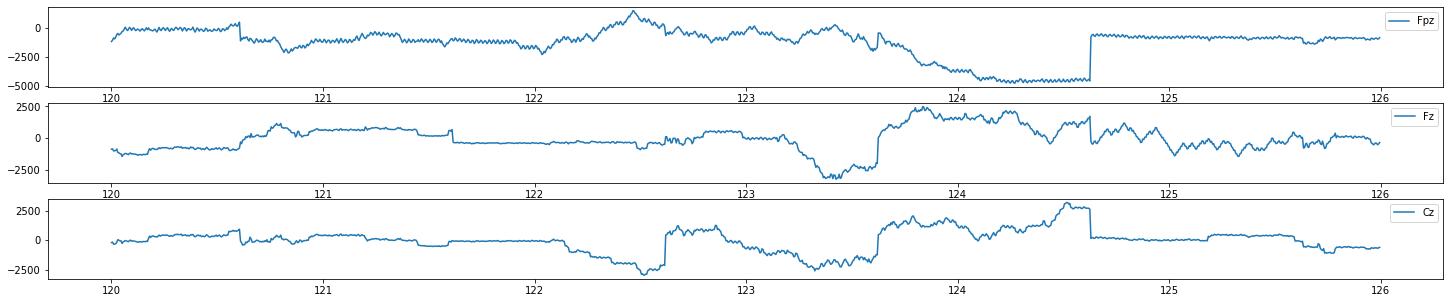

In [314]:
#1er nettoyage (slow drift et référence) et 1er AFFICHAGE
#nettoyage : notch à 50 Hz, filtre passe-haut pour les slow-drifts et mise à 0 du signal
raw.notch_filter(50)
raw.filter(l_freq=0.2,h_freq=None)
raw.set_eeg_reference('average',projection=True,verbose=False)

#affichage
eeg_array = raw.get_data()
#fenêtre d'affichage
debut=120
fin=126
f_e=int(raw.info['sfreq'])
time=raw.times[debut*f_e:fin*f_e]
amplitude_2=eeg_array[1][debut*f_e:fin*f_e]
amplitude_3=eeg_array[2][debut*f_e:fin*f_e]
amplitude_4=eeg_array[3][debut*f_e:fin*f_e]

plt.figure(figsize=(25,5))
plt.subplot(3,1,1)
plt.plot(time,amplitude_2,label="Fpz")
plt.legend()

plt.subplot(3,1,2)
plt.plot(time,amplitude_3,label="Fz")
plt.legend()

plt.subplot(3,1,3)
plt.plot(time,amplitude_4,label="Cz")
plt.legend()

plt.show()

In [315]:
#raw.plot(scalings={'eeg':'auto','misc':1e4})

**Management des triggers**

In [316]:
#il y a des erreurs lors de l'enregistrement des logs : ce script permet de les réparer et de les contourner
length = time_click.shape[0]
print(length)
#missing runs
if error1.shape[0]!=length or error2.shape[0]!=length or player.shape[0]!=length:
    print("il y a eu un problème lors de l'enregistrement des logs. Ce problème sera contourné dans la suite")
    #recherche des essais râtés
    for i in range(0,length):
        if i< error1.shape[0] and int(error1[i][0]) != (i+1):
            print("erreur à l'indice",i," dans la liste d'erreurs 1")
            row = np.array([str(i+1),'reject'])
            error1 = np.insert(error1,i,[row],axis= 0)
        if i< error2.shape[0] and int(error2[i][0]) != (i+1):
            print("erreur à l'indice",i," dans la liste d'erreurs 2")
            row = np.array([str(i+1),'reject'])
            error2 = np.insert(error2,i,[row],axis= 0)
        if i< player.shape[0] and int(player[i][0]) != (i+1):
            print("erreur à l'indice",i," dans la liste player")
            row = np.array([str(i+1),'reject'])
            player = np.insert(player,i,[row],axis= 0)
            
#maintenant toutes les listes ont la même taille et on sait quels essais il faut rejeter   
#2006_2         
row = np.array([str(132),'reject'])
error2 = np.insert(error2,100,[row],axis= 0)
print(trigger_list.shape[0]," pics sont attendus")

104
il y a eu un problème lors de l'enregistrement des logs. Ce problème sera contourné dans la suite
erreur à l'indice 21  dans la liste d'erreurs 2
erreur à l'indice 53  dans la liste d'erreurs 2
erreur à l'indice 75  dans la liste d'erreurs 2
294  pics sont attendus


durée de l'expérimentation:  5 min 52
Found 301 significant peaks
il reste  301 pics
avant : (70433,)
après : (1, 70433)


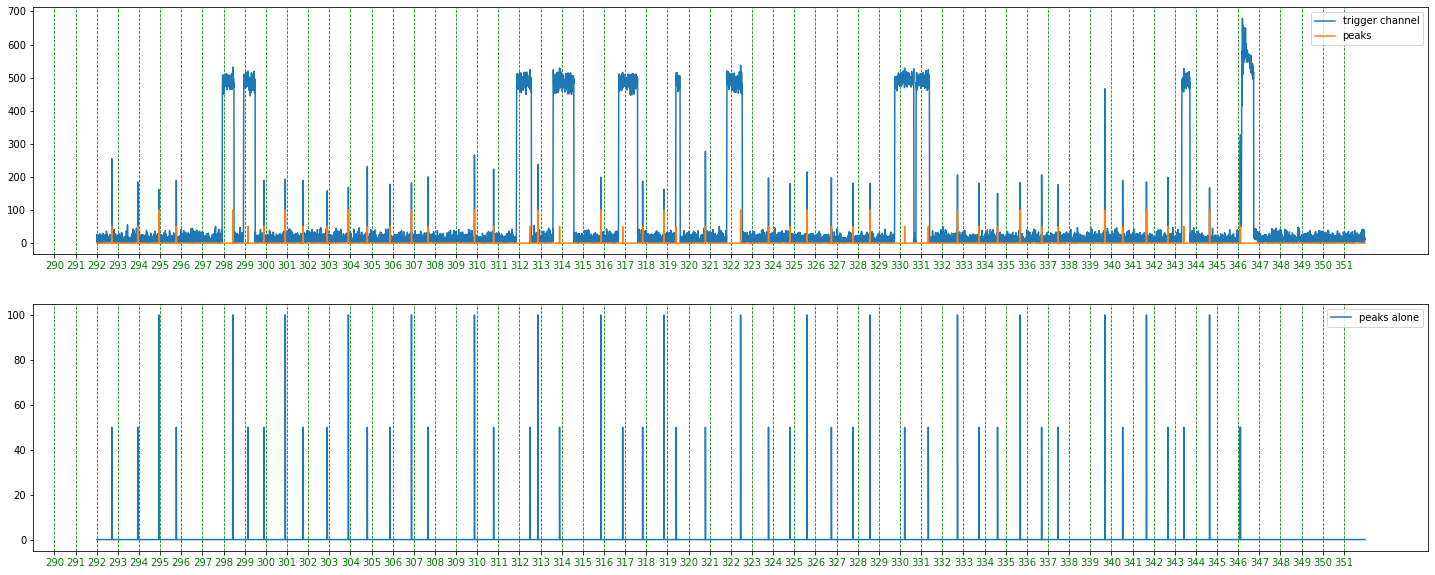

In [317]:
#peak = -raw.get_data()[0][debut*f_e:fin*f_e]
debut=0
fin=(1/f_e)*data.shape[1]
fin = np.int(fin)
print("durée de l'expérimentation: ",fin//60,"min",fin%60)
trigger = raw.get_data()[0]
f_e=int(raw.info['sfreq'])
time=raw.times


#find peak
peak_loc,peak_mag = mne.preprocessing.peak_finder(np.abs(trigger),80)
#adaptation
new_peaks = []
new_mags = []
for k in range(peak_mag.shape[0]):
  if peak_mag[k] >=1:
    new_peaks.append(peak_loc[k])
    new_mags.append(peak_mag[k])

#EN FONCTION DES TESTS, il y a eu différents problèmes sur le canal trigger    

#pour 21
"""print("avant",len(new_peaks))
del new_peaks[0:1046]
new_peaks[212:217]
print("après", len(new_peaks))"""

#pour 5 si 55
"""del new_peaks[0]
del new_peaks[79:82]
del new_peaks[174]
del new_peaks[291:293]
del new_peaks[391]
del new_peaks[453]"""
#if 88
"""del new_peaks[64:66]
del new_peaks[234]
del new_peaks[448]"""


#for 31
"""del new_peaks[0:11]
del new_peaks[152:]
del new_peaks[48]"""

#for test_son 4
#del new_peaks[18:23]

#for test 2006
#del new_peaks[len(new_peaks)-5:len(new_peaks)]

#for 84 : detection at 90

#for 69 with detection at 110
"""del new_peaks[132]
del new_peaks[243]
del new_peaks[242]
del new_peaks[-1]
del new_peaks[-1]
del new_peaks[-1]"""

#for 9922
"""del new_peaks[0]
del new_peaks[3:11]"""

#for 201
#trigger_list = np.delete(trigger_list,[82])
#trigger_list[82]="aff rej"
#trigger_list = np.delete(trigger_list,240)
"""del new_peaks[136]
#trigger_list = np.delete(trigger_list,[188])
del new_peaks[294:300]
trigger_list[-1]='feedback rejeté'"""
#del new_peaks[47]

#for 12
"""del new_peaks[0]
del new_peaks[344:350]"""

#for 15
"""del new_peaks[272]
del new_peaks[-1]"""

#for 6478
"""del new_peaks[:28]
del new_peaks[:17]
del new_peaks[353:395]"""

peaks = np.zeros((trigger.shape[0]))

for k in range(min(trigger_list.shape[0],len(new_peaks))):
  if new_peaks[k]>0 :
    if trigger_list[k]=='Affichage':
      peaks[new_peaks[k]] = 100
    elif trigger_list[k]!='Affichage' :
      peaks[new_peaks[k]] = 50
    
peaks[new_peaks[18]] = 200
"""else:
      peaks[new_peaks[k]] = 50"""

axis = []
for k in range(fin):
  axis.append(k)

print("il reste ", len(new_peaks), "pics")
debut,fin = fin-60,fin
plt.figure(figsize=(25,10))
axes = plt.gca()
plt.subplot(211)
plt.xticks(axis, color = 'g')
plt.grid(which='major', axis='x', color='g', linestyle='dashed')
plt.plot(time[debut*f_e:fin*f_e],np.abs(trigger[debut*f_e:fin*f_e]),label="trigger channel")
plt.plot(time[debut*f_e:fin*f_e],peaks[debut*f_e:fin*f_e],label = "peaks")

plt.legend()

plt.subplot(212)
plt.xticks(axis, color = 'g')
plt.grid(which='major', axis='x', color='g', linestyle='dashed')
plt.plot(time[debut*f_e:fin*f_e],peaks[debut*f_e:fin*f_e],label = "peaks alone")
plt.legend()


#modification de la taille du tableau pour la suite
print("avant :", peaks.shape)
peaks = np.resize(peaks,(1,peaks.shape[0]))
print("après :", peaks.shape)

In [318]:
#LABELLISATION
label_2=list(trigger_list[0:trigger_list.shape[0]])
#on va parcourir label_2 pour lui assigner les triggers erronés en parcourant error 1 et error 2
count=-1
for k in range(len(label_2)):
    if label_2[k]=='Affichage':
        count += 1
    if label_2[k]=="aff rej":
        label_2[k]="Affichage rejeté"
    #si essai rejeté
    if count < min(error1.shape[0],error2.shape[0],player.shape[0]):
        if error1[count][1]=='reje' or error2[count][1]=='reje' or player[count][1]=='reje':
            if label_2[k]=='Affichage':
                print("affichage rejeté",count)
                label_2[k]="Affichage rejeté"    
            if label_2[k]=='Clic':
                label_2[k]="Clic rejeté"  
                print("Clic rejeté",count,k)  
            if label_2[k]=='feedback' or label_2[k]=="feedback avec erreur":
                label_2[k]="feedback rejeté"
                print("feedback rejeté",count)  
        elif error1[count][1]!='reje' and error2[count][1]!='reje' and player[count][1]!='reje':
            if label_2[k]=='Clic':
                if error1[count][1]=='1':
                    label_2[k]="Clic avec erreur 1"    
            if label_2[k]=='feedback':
                if error2[count][1]=='1':
                    label_2[k]="feedback avec erreur"

#compte des erreurs du joueur
count_error = 0
for k in range(player.shape[0]):
    if player[k][1]!=attendus[k] and error1[k][1]=='0':
        count_error+=1
print("il y a eu",count_error,"erreurs sur",player.shape[0],"essais (",count_error/player.shape[0],")")

affichage rejeté 21
Clic rejeté 21 64
feedback rejeté 21
affichage rejeté 53
Clic rejeté 53 150
feedback rejeté 53
affichage rejeté 75
Clic rejeté 75 216
feedback rejeté 75
affichage rejeté 100
Clic rejeté 100 284
feedback rejeté 100
il y a eu 3 erreurs sur 104 essais ( 0.028846153846153848 )


In [319]:
#création d'un type raw avec le canal de trigger nettoyer en canal 'stim'
raw.filter(l_freq=0,h_freq=10)
eeg = raw.get_data()
#pour 5
#data = np.concatenate((eeg[3:5],eeg[2:3]))
data = np.concatenate((peaks,eeg[1:4]),axis = 0)
n_channels = 4
ch_names=['trigger','Fpz','Fz','Cz']
ch_types=['stim','eog','eeg','eeg']
f_e=200 #Hz
info_data=mne.create_info(ch_names,ch_types=ch_types,sfreq=f_e)
print(info_data)
time=np.linspace(0,(1/f_e)*data.shape[1],data.shape[1]) #variable temps
#création du type Array
raw=mne.io.RawArray(data,info_data)
montage=mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage,match_case=True)
#raw.savgol_filter(10,verbose = None)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 265 samples (1.325 sec)

<Info | 7 non-empty values
 bads: []
 ch_names: trigger, Fpz, Fz, Cz
 chs: 1 Stimulus, 1 EOG, 2 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 200.0 Hz
>
Creating RawArray with float64 data, n_channels=4, n_times=70433
    Range : 0 ... 70432 =      0.000 ...   352.160 secs
Ready.


<ipython-input-319-79ae1f31775f>:17: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fpz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage,match_case=True)


<RawArray | 4 x 70433 (352.2 s), ~2.2 MB, data loaded>

Effective window size : 10.240 (s)


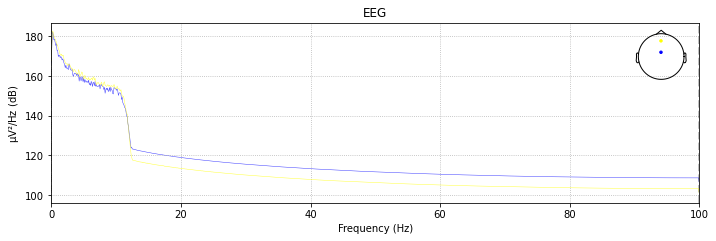

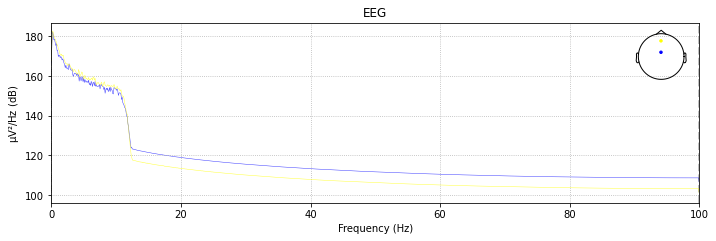

In [320]:
raw.plot_psd()

**Gestion des events**

In [321]:
events = mne.find_events(raw, stim_channel='trigger')
print("RAPPEL: ",trigger_list.shape[0]," pics sont attendus")

294 events found
Event IDs: [ 50 100 200]
RAPPEL:  294  pics sont attendus


Il y a 12 triggers rejetés


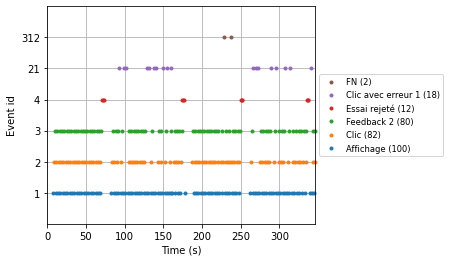

In [322]:
count = 0
count_reject=0
label = label_2
for k in range(min(events.shape[0],trigger_list.shape[0])):
    if label[k]=="Affichage":
        events[k][2]=1
    if label[k]=="Affichage sans clic":
        events[k][2]=11
    if label[k] == "Clic":
        events[k][2]=2
    if label[k] == "Clic avec erreur 1":
        events[k][2]=21
    if label[k]=="feedback":
        count += 1
        events[k][2]=3
    if label[k]=="feedback avec erreur":
        if player[count][1]!=attendus[count]:
            #faux positif
            events[k][2]=311
        elif player[count][1]==attendus[count]:
            #faux négatif
            events[k][2]=312
        count += 1
    if label[k]=="Affichage rejeté" or label[k]=="Clic rejeté" or label[k]=="feedback rejeté":
        count += 1
        count_reject += 1
        events[k][2]=4
print("Il y a",count_reject,"triggers rejetés")

#affichage de la distribution des events au long du jeu
event_dict = {'Affichage': 1,'Clic': 2, 'Feedback 2':3, 'Clic avec erreur 1': 21, 'FN':312,'Essai rejeté':4} # ,'FP':311, 'Feedback 2 avec erreur':31, 'Affichage sans clic': 11, 'Clic avec erreur 1': 21,  'Affichage sans clic': 11
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp,event_id = event_dict)
fig.subplots_adjust(right=1)  # make room for legend

**Création des epochs**

In [323]:
epochs = mne.Epochs(raw,events,tmin=-0.3,tmax=1,baseline = (-0.3,0),event_id = event_dict,preload = True) #, preload = True

Not setting metadata
294 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 294 events and 261 original time points ...
0 bad epochs dropped


*- Rejet des bads epochs à la main*

In [324]:
epochs.plot(scalings={'eeg':'auto','misc':1e4})

Opening epochs-browser...


*Autoreject*

In [325]:
import autoreject
ar = autoreject.AutoReject(n_interpolate=[1, 2, 3, 4], random_state=11,
                           n_jobs=1, verbose=True)
ar.fit(epochs)  # fit on a few epochs to save time
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

100%|██████████| Creating augmented epochs : 2/2 [00:00<00:00,   69.15it/s]
  0%|          | Computing thresholds ... : 0/2 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


100%|██████████| Computing thresholds ... : 2/2 [00:02<00:00,    1.49s/it]














































100%|██████████| Repairing epochs : 294/294 [00:00<00:00,  361.70it/s]


























































































































100%|██████████| Repairing epochs : 294/294 [00:02<00:00,  119.46it/s]






















100%|██████████| Fold : 10/10 [00:00<00:00,   33.31it/s]

c:\Users\cassa\anaconda3\lib\site-packages\mne\bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\cassa\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\cassa\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\cassa\anaconda3\lib\site-packages\numpy\core\_methods.py:162: RuntimeW





Estimated consensus=0.60 and n_interpolate=1
































































































































100%|██████████| Repairing epochs : 294/294 [00:02<00:00,  111.95it/s]

Dropped 156 epochs: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 20, 21, 22, 23, 24, 25, 32, 37, 38, 40, 41, 42, 43, 47, 48, 50, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 72, 73, 76, 77, 78, 86, 87, 88, 89, 90, 91, 92, 93, 96, 97, 103, 104, 105, 108, 109, 110, 111, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 198, 199, 200, 201, 208, 218, 219, 220, 221, 222, 223, 224, 227, 228, 232, 233, 234, 238, 239, 249, 251, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 266, 267, 271, 272, 275, 276, 277, 278, 279, 280, 281, 284, 285, 286, 287, 290, 292, 293


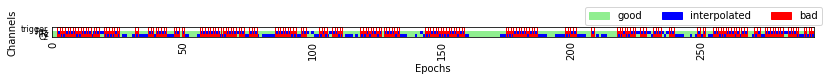

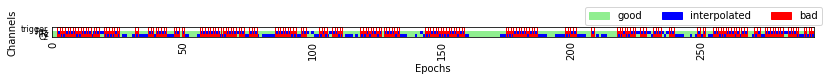

In [326]:
#pour voir ce qui a été rejeté
reject_log.plot('horizontal')

*Avec matplotlib*

In [327]:
#fn=epochs['FN'].get_data()
f=epochs['Feedback 2'].get_data()
missclic=epochs['Clic avec erreur 1'].get_data()
clic = epochs['Clic'].get_data()

In [328]:
missclic_Fz = missclic[:,2,:]
missclic_Cz = missclic[:,3,:]
clic_Fz = np.mean(clic[:,2,:],axis=0)
clic_Cz = np.mean(clic[:,3,:],axis=0)
time = np.linspace(-1,1,missclic_Fz[0,:].shape[0])

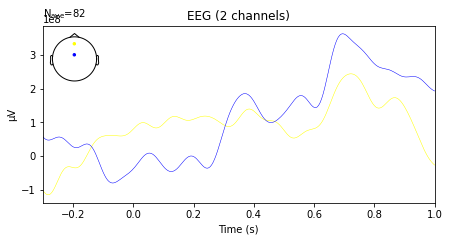

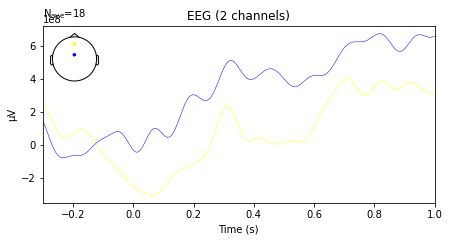

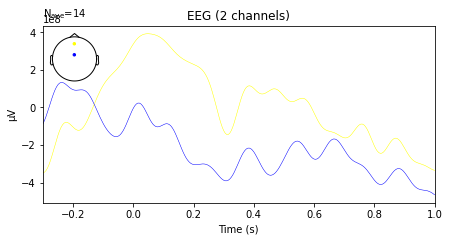

In [329]:
clic = epochs['Clic'].average()
clic_error = epochs['Clic avec erreur 1'].average()
difference_clic = mne.combine_evoked([clic,clic_error], weights=[1,-1])
fig1 = clic.plot(spatial_colors = True)
fig2 = clic_error.plot(spatial_colors = True)
fig3 = difference_clic.plot(spatial_colors = True)

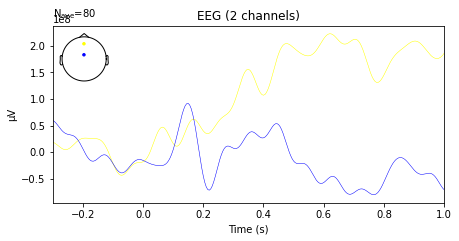

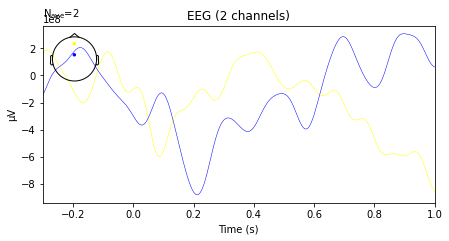

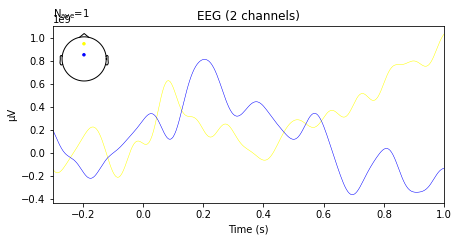

In [330]:
feedback = epochs['Feedback 2'].average()
feedback_error = epochs['FN'].average()
difference = mne.combine_evoked([feedback,feedback_error], weights=[1,-1])
fig1 = feedback.plot(spatial_colors=True)
fig2 = feedback_error.plot(spatial_colors = True)
fig3 = difference.plot(spatial_colors = True)

In [331]:
evokeds_to_plot = dict(clic=list(epochs['Clic'].iter_evoked()),
               clic_erreur= list(epochs['Clic avec erreur 1'].iter_evoked()))   

combining channels using "mean"
combining channels using "mean"


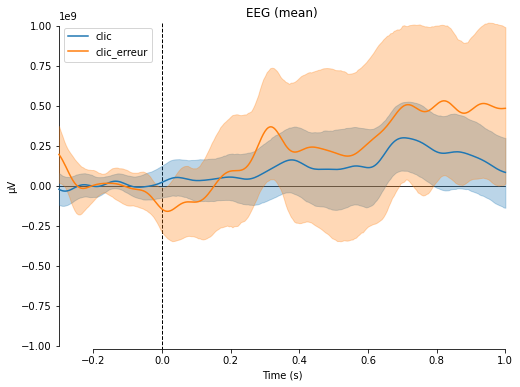

[<Figure size 576x432 with 1 Axes>]

In [332]:
mne.viz.plot_compare_evokeds(evokeds_to_plot,picks='eeg',combine = 'mean')

combining channels using "mean"


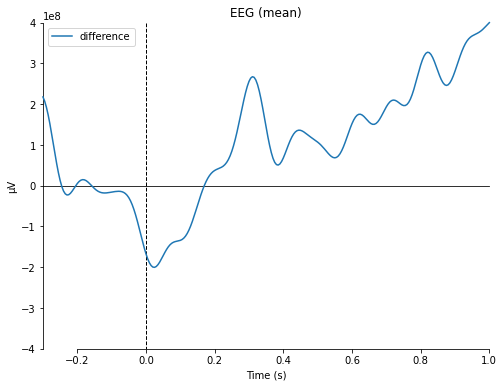

combining channels using "std"


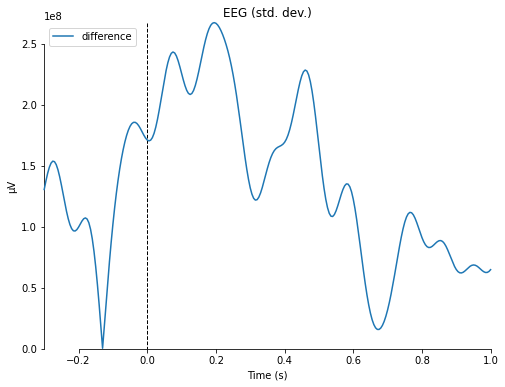

[<Figure size 576x432 with 1 Axes>]

In [333]:
mne.viz.plot_compare_evokeds(dict(difference=mne.combine_evoked([clic,clic_error], weights=[-1,1])),picks='eeg',combine = 'mean')
mne.viz.plot_compare_evokeds(dict(difference=mne.combine_evoked([clic,clic_error], weights=[-1,1])),picks='eeg',combine = 'std')

In [334]:
evokeds_to_plot = dict(feedback = list(epochs['Feedback 2'].iter_evoked()),
               feedback_erreur = list(epochs['FN'].iter_evoked()))   

combining channels using "mean"
combining channels using "mean"


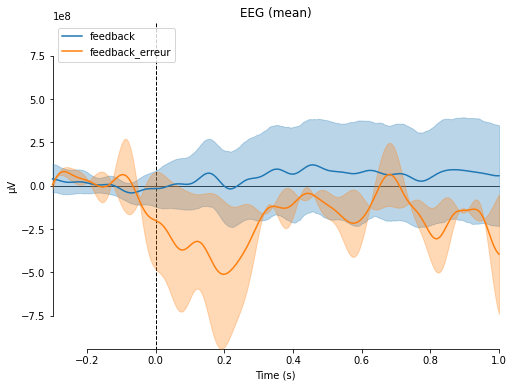

[<Figure size 576x432 with 1 Axes>]

In [335]:
mne.viz.plot_compare_evokeds(evokeds_to_plot,picks='eeg',combine = 'mean')

combining channels using "mean"


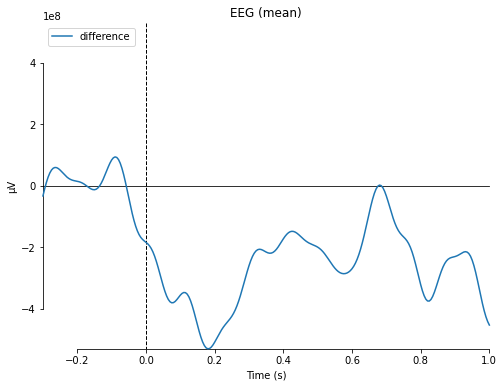

[<Figure size 576x432 with 1 Axes>]

In [336]:
mne.viz.plot_compare_evokeds(dict(difference=mne.combine_evoked([feedback,feedback_error], weights=[-1,1])),picks='eeg',combine = 'mean')

Enregistrement des différences au format txt

In [337]:
np.savetxt(os.path.join("Results","difference",file+"feedback"+".txt"),mne.combine_evoked([feedback,feedback_error], weights=[-1,1]).get_data())
np.savetxt(os.path.join("Results","difference",file+"clic"+".txt"),mne.combine_evoked([clic,clic_error], weights=[-1,1]).get_data())

In [338]:
test = np.genfromtxt(os.path.join("Results","difference",file+"feedback"+".txt"))

In [339]:
norm = np.linalg.norm(test,1)
test_norm = test/norm

In [340]:
test_norm

array([[ 1.17406594e-01,  1.33740496e-01,  1.43861670e-01,
         1.47897954e-01,  1.46303651e-01,  1.39839551e-01,
         1.29431646e-01,  1.16039339e-01,  1.00595522e-01,
         8.39139896e-02,  6.66294829e-02,  4.91542183e-02,
         3.17264955e-02,  1.43828266e-02, -2.95684579e-03,
        -2.04415597e-02, -3.82342897e-02, -5.64453882e-02,
        -7.50634233e-02, -9.39417721e-02, -1.12778581e-01,
        -1.31135469e-01, -1.48411774e-01, -1.63910278e-01,
        -1.76867854e-01, -1.86517407e-01, -1.92153504e-01,
        -1.93167402e-01, -1.89105605e-01, -1.79686186e-01,
        -1.64846642e-01, -1.44751037e-01, -1.19790034e-01,
        -9.05945934e-02, -5.80091289e-02, -2.30917222e-02,
         1.29308251e-02,  4.87096375e-02,  8.28122706e-02,
         1.13795859e-01,  1.40257143e-01,  1.60957040e-01,
         1.74841427e-01,  1.81185453e-01,  1.79627873e-01,
         1.70246405e-01,  1.53568021e-01,  1.30565684e-01,
         1.02614213e-01,  7.14171446e-02,  3.88733997e-0

    Using multitaper spectrum estimation with 7 DPSS windows


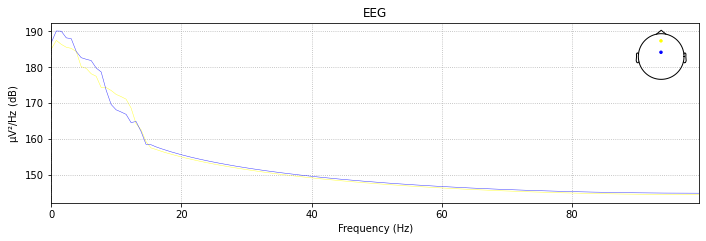

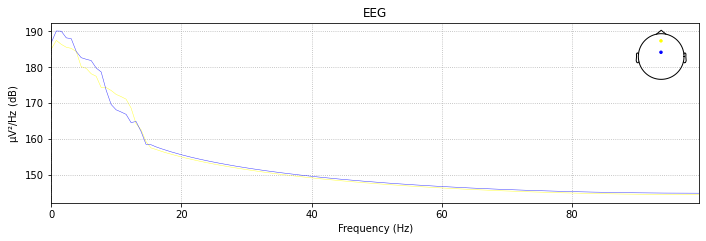

In [346]:
epochs['FN'].plot_psd()

    Using multitaper spectrum estimation with 7 DPSS windows


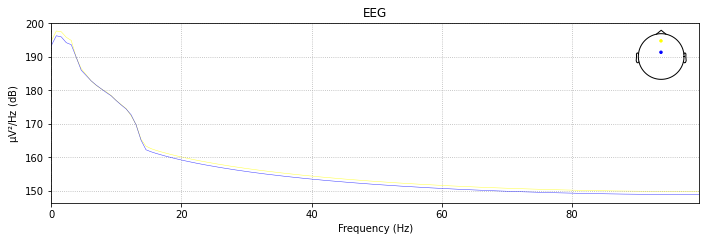

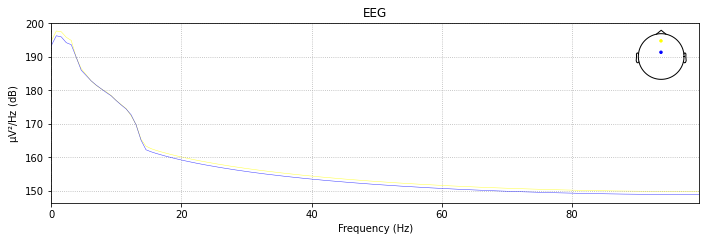

In [347]:
epochs['Feedback 2'].plot_psd()

In [344]:
l=['2','3']
str('feedback'+l[0])=[1,2]

SyntaxError: cannot assign to function call (<ipython-input-344-e146bf17b1e2>, line 2)